# Detection: Test Your Model on Images Showing Objects in Background

### Pipeline
1. Load & display images
2. Extract ORB keypoints/descriptors
3. Visualise **all** raw keypoints (red)
4. Apply NMS
5. Visualise **retained** keypoints (green)
6. Save the NMS‑pruned descriptors (`.npy`) and keypoint metadata (`.csv`)

**Dependencies**: `opencv-python`, `numpy`, `matplotlib`.

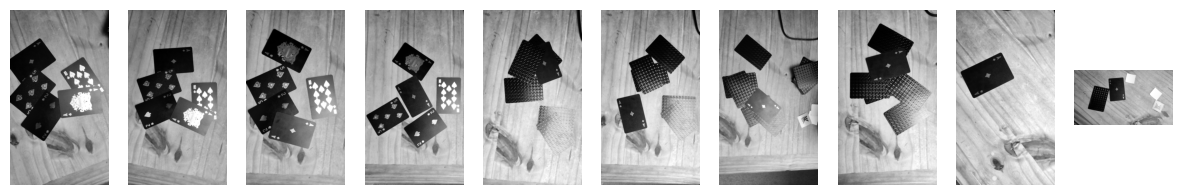

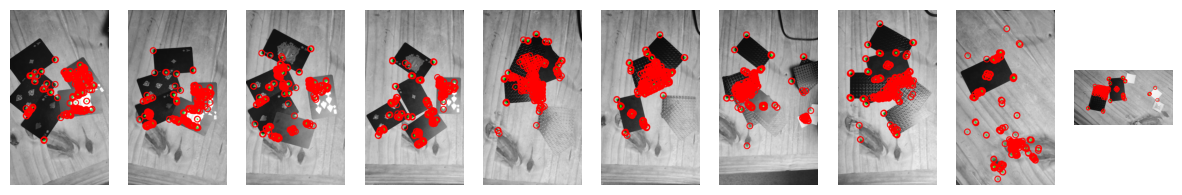

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import csv

# 1. Load & display images
image_files = sorted(os.listdir("real_pics"))
images = [cv2.imread(os.path.join("real_pics", img)) for img in image_files]

images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
images = [cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA) for img in images]
images = [cv2.medianBlur(img, ksize=5) for img in images]

fig, axes = plt.subplots(1, len(images), figsize=(15, 8))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

# 2. Extract keypoints/descriptors
img_keyp_pairs = []
descriptors_dict = {}
keypoints_dict = {}

orb = cv2.ORB_create()
for i in range(len(images)):
    keypoints, descriptors = orb.detectAndCompute(images[i], None)

    for keyp in keypoints:
        keyp.size *= 5

    keypoints_dict[image_files[i]] = keypoints
    
    descriptors_dict[image_files[i]] = {}
    for k in range(len(keypoints)):
        descriptors_dict[image_files[i]][keypoints[k]] = descriptors[k]

# 3. Visualise all raw keypoints
images_with_keypoints = []
for i in range(len(images)):
    images_with_keypoints.append(cv2.drawKeypoints(images[i], keypoints_dict[image_files[i]], None, color=(0, 255, 0), flags=0))
    
    for keyp in keypoints_dict[image_files[i]]:
        cv2.circle(images_with_keypoints[-1], tuple(int(c) for c in keyp.pt), radius=15, color=(255, 0, 0), thickness=3)
    
fig, axes = plt.subplots(1, len(images_with_keypoints), figsize=(15, 5))
for ax, img in zip(axes, images_with_keypoints):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()


In [2]:
# 4. Apply NMS
neighborhood_size = 1/4 #the used pictures have too fine details for nms with keypoint size/2 to be effective

keypoints_nms = {}
for i in range(len(images)):
    keypoints = sorted(keypoints_dict[image_files[i]], key=lambda x: x.response, reverse=True)
    
    keep_points = []

    for keyp in keypoints:
        keep = True

        keep = all(np.linalg.norm(np.array(keepp.pt) - np.array(keyp.pt)) > keepp.size*neighborhood_size for keepp in keep_points)

        if keep:
            keep_points.append(keyp)
        
    keypoints_nms[image_files[i]] = keep_points


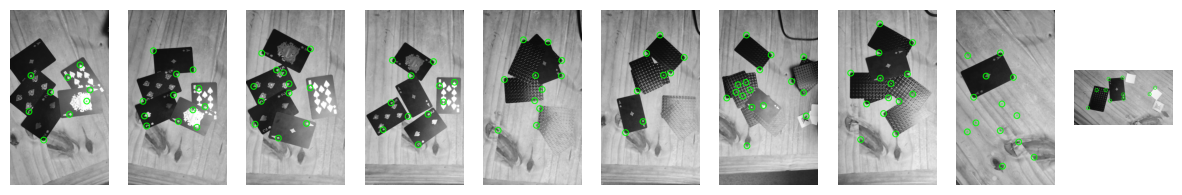

In [3]:
# 5. Visualise retained keypoints
images_with_keypoints = []
for i in range(len(images)):
    images_with_keypoints.append(cv2.drawKeypoints(images[i], keypoints_nms[image_files[i]], None, color=(0, 255, 0), flags=0))
    
    for keyp in keypoints_nms[image_files[i]]:
        cv2.circle(images_with_keypoints[-1], tuple(int(c) for c in keyp.pt), radius=15, color=(0, 255, 0), thickness=3)
    
fig, axes = plt.subplots(1, len(images_with_keypoints), figsize=(15, 5))
for ax, img in zip(axes, images_with_keypoints):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()


In [4]:

# save
all_descriptors = []
for i in range(len(images)):
    for keyp in keypoints_nms[image_files[i]]:
        all_descriptors.append(descriptors_dict[image_files[i]][keyp])
np.save("descriptors.npy", descriptors)

all_keypoint_data = []
for i in range(len(images)):
    all_keypoint_data.extend(k for k in keypoints_nms[image_files[i]])
all_keypoint_data = [(k.pt[0], k.pt[1], k.size, k.angle, k.response, k.octave) for k in all_keypoint_data]
with open("keypoints.csv", "w", newline="") as file:
    w = csv.writer(file)
    w.writerow(["x", "y", "size", "angle", "response", "octave"])
    w.writerows(all_keypoint_data)


## Load object & background cluster models
Load model data:
- **Object** clusters: `orb_allfeatures_cow/cluster_centers.npy` and their displacement lists `cluster_displacements.json`.
- **Background** clusters: `orb_allfeatures_background_images/cluster_centers.npy`.

Executed once before processing test images.

In [5]:
# 16. Load object & background cluster models¶
import json

with open("cluster_displacements.json", "r") as file:
    data = json.load(file)

all_cluster_displacements = {eval(k): [np.array(a) for a in v] for k,v in data.items()}

# load bg
bg_data = np.load("bg.npz")

positions = bg_data["positions"]
sizes = bg_data["sizes"]
angles = bg_data["angles"]
responses = bg_data["responses"]
octaves = bg_data["octaves"]
descriptors = bg_data["descriptors"]

## Assign test keypoint feature descriptors to nearest cluster (codebook entry / visual word) and keep object keypoints only

In [6]:
# 17. Assign test keypoint feature descriptorss to nearest cluster (codebook entry / visual word) and keep object keypoints only


img_w_kp_and_disps = []

cluster_vectors = [np.array(centoid) for centoid in list(all_cluster_displacements.keys())]

for i in range(len(image_files)):
    im = image_files[i]
    img_t = cv2.drawKeypoints(images[i], keypoints_nms[im], None, color=(255, 255, 0), flags=0)
    
    for keyp in keypoints_nms[im]:
            descriptor = descriptors_dict[im][keyp]

            distance_vector = [np.linalg.norm(descriptor - des_arr) for des_arr in cluster_vectors]
            idx_of_most_similar = np.argmin(distance_vector)
                                               
            for d in range(len(all_cluster_displacements[tuple(cluster_vectors[idx_of_most_similar])])):
                point = np.array(keyp.pt)
                offset = np.array(all_cluster_displacements[tuple(cluster_vectors[idx_of_most_similar])][d])
                
                endpoint = tuple((point - offset).astype(int))
                startpoint = tuple(point.astype(int))

                img_t = cv2.circle(img_t, startpoint, 25, (0, 255, 0), 5)
                img_t = cv2.arrowedLine(img_t, startpoint, endpoint, color=(0,0,255), thickness=2)

    img_w_kp_and_disps.append(img_t)

## Voting procedure

Visualise object votes (displacement vectors from cluster). 

Here it is done on the test images and not on the training images only. So this is the application of the Implicit Shape Model to real data.

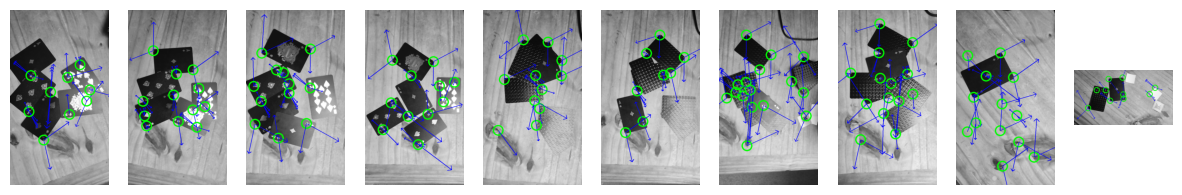

In [7]:
# 18. Visualise object votes (same as in training jupyter notebook)

fig, axes = plt.subplots(1, len(img_w_kp_and_disps), figsize=(15, 5))
for ax, img in zip(axes, img_w_kp_and_disps):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

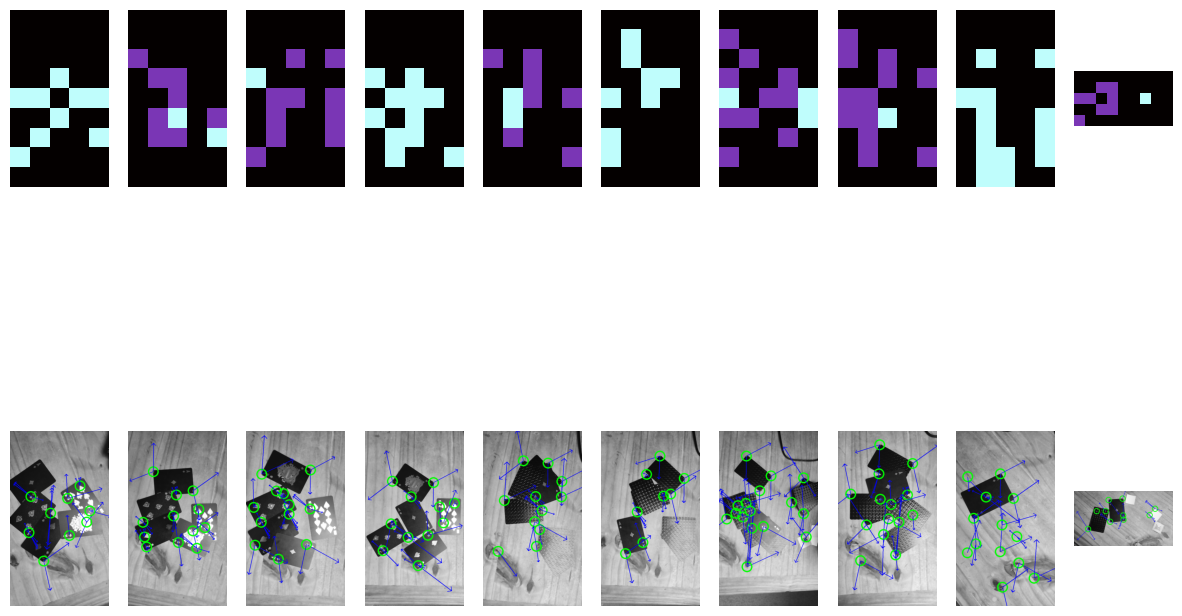

In [8]:
# 19. Cast votes to low resolution grid bins and visualize (same as in training jupyter notebook)

scale = 1/96
maps = []

cluster_vectors = [np.array(centoid) for centoid in list(all_cluster_displacements.keys())]

for i in range(len(image_files)):
    im = image_files[i]

    height, width = images[i].shape
    height = (int)(height*scale)
    width = (int)(width*scale)

    heatmap = np.zeros((height, width), dtype=np.float32)
    
    for keyp in keypoints_nms[im]:
        descriptor = descriptors_dict[im][keyp]

        distance_vector = [np.corrcoef(descriptor - des_arr) for des_arr in cluster_vectors]
        idx_of_most_similar = np.argmax(distance_vector)

        point = np.array(keyp.pt)
        offset = np.array(all_cluster_displacements[tuple(cluster_vectors[idx_of_most_similar])])
        
        endpoint = tuple((point - offset).astype(int)[0])
        x, y = endpoint

        heatmap[(int)((y*scale)%height), (int)((x*scale)%width)] += 1

    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_MAGMA)

    maps.append(heatmap)


fig, axes = plt.subplots(2, len(maps), figsize=(15, 10))
for i, (map, img) in enumerate(zip(maps, img_w_kp_and_disps)):
    axes[0, i].imshow(map, cmap="grey")
    axes[1, i].imshow(img, cmap="grey")
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()

# Discussion

Discuss the achievements of you **prototype** Implicit Shape Model:

- Are the result reasonable in principle?
- What are the deficits?
- Suggest improvements:
    - Does your approach make use of an angle or a direction of the keypoint?
    - If not, what would you need to change?
    - Does your approach make use of a size or scale of the keypoint?
    - If not, what would you need to change?
    - What are the implications concerning rotations or size/scale changes of your images?
    - Can you reduce the complexity of your task by providing other training and test data?
    
If you have the time, try to realize some of the suggested improvements.

Based on the images selected, the poor performance in the test cases is kind of understandable. With the large number of keypoints that are similar for every card, which in tern are oftentimes symmetric, we assume that no perfectly identifying feature of the ace of diamonds is represented strongly enough. This might also be since, for instance corners, which feature keypoints for the corners itself and for the four corners of the diamond symbol get combined into a singular keypoint, that does not represent either a corner, nor a diamond in a good way.
The overall extraction and clustering of keypoints with the addition of computing displacement vectors does work resonably well. Adding the angle of the keypoint to the displacements would be expected to vastly increase the models performance, due to the inherent symmetry of the keypoints in question. To add angle into the equasion, the displacement direction that has been calculated for every step would need to be normalised with respect to the angle of the keypoint it has been infered from and taken into concideration during application on test images. Similarly, the size should be normalised and applied in a similar fashion during training and testing. 
Taking size and roatation into account is expected to vastly improve the models performance. 